# Setup

In [2]:
import glob

import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image
%matplotlib inline

/Users/jay/.pyenv/versions/3.7.5/envs/microscan/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
dir_path = "data/base microstructure"
img_num = 141
img_path = "{}/image_{}.png".format(dir_path, img_num)
gb_mask_path = "{}/gbmask_{}.png".format(dir_path, img_num)
lam_mask_path = "{}/lammask_{}.png".format(dir_path, img_num)
p1_mask_path = "{}/p1mask_{}.png".format(dir_path, img_num)
p2_mask_path = "{}/p2mask_{}.png".format(dir_path, img_num)
prec_mask_path = "{}/precmask_{}.png".format(dir_path, img_num)

In [4]:
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
gb_mask = cv2.imread(gb_mask_path, cv2.IMREAD_GRAYSCALE)
lam_mask = cv2.imread(lam_mask_path, cv2.IMREAD_GRAYSCALE)
p1_mask = cv2.imread(p1_mask_path, cv2.IMREAD_GRAYSCALE)
p2_mask = cv2.imread(p2_mask_path, cv2.IMREAD_GRAYSCALE)
prec_mask = cv2.imread(prec_mask_path, cv2.IMREAD_GRAYSCALE)

In [5]:
total_pixels = len(img.flatten())

def plot_all(images):
    columns = 3
    rows = 2
    
    fig=plt.figure(figsize=(12, 6))
    for i in range(1, columns*rows + 1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i-1], cmap="gray")

    plt.show()
    
def save_image(image):
    cv2.imwrite("temp.png", image)

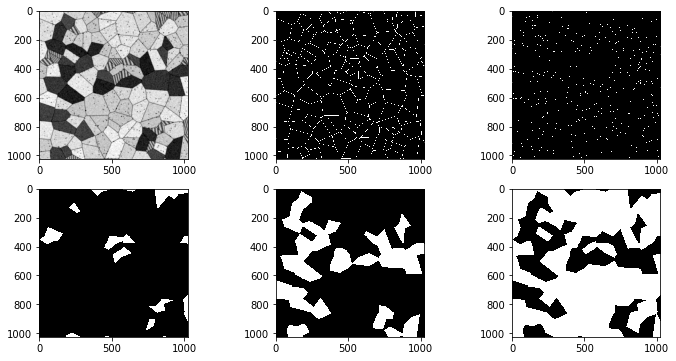

In [6]:
plot_all([img, gb_mask, prec_mask, lam_mask, p1_mask, p2_mask])

# Boundaries

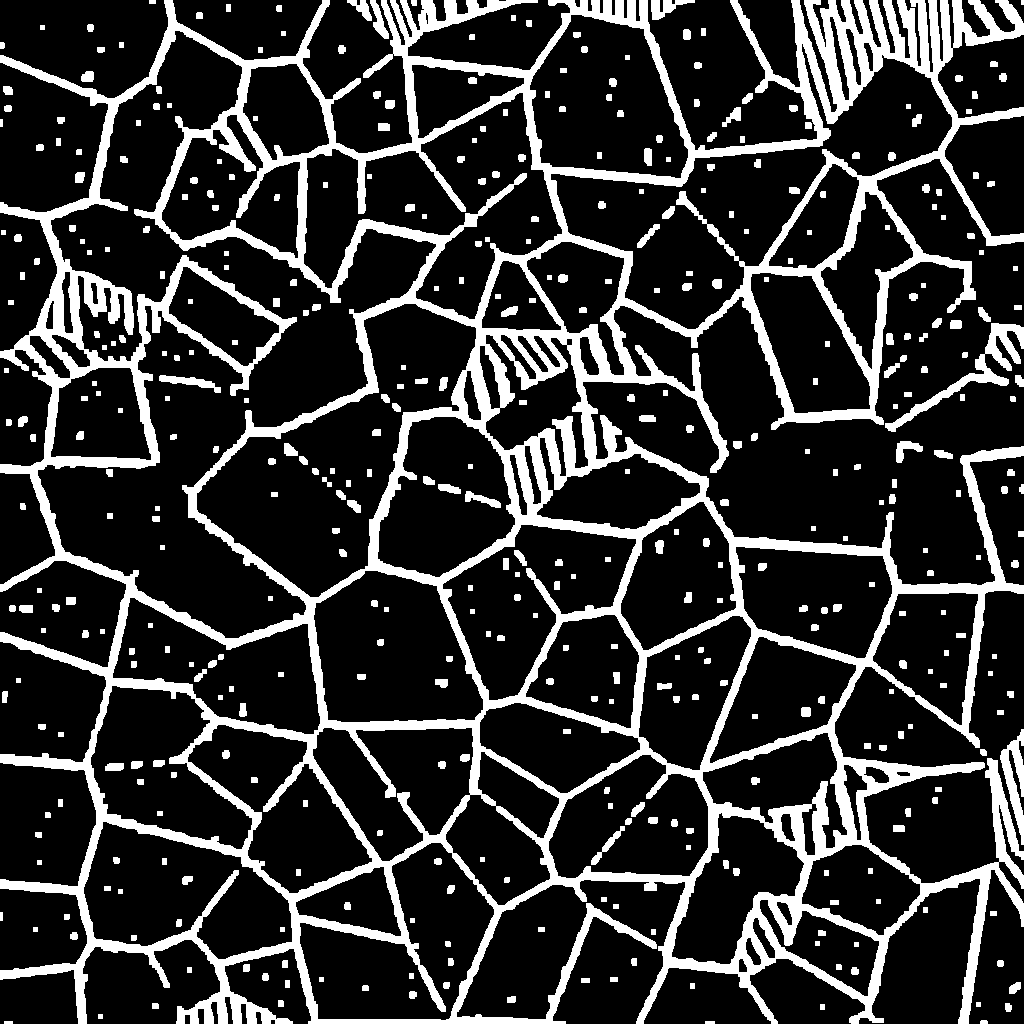

In [9]:
def bounds(image):
    thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    _, thresh = cv2.threshold(thresh, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    kernel = np.ones((1, 5), np.uint8)
    horizontal = cv2.erode(thresh, kernel, iterations=2)

    kernel = np.ones((5, 1), np.uint8)
    vertical = cv2.erode(thresh, kernel, iterations=2)

    edges = horizontal + vertical
    edges = np.array(np.where(edges == 255, 255, 0), np.uint8)

    return edges

def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    dilated = cv2.dilate(image, kernel, iterations=1)
    return dilated

save_image(dilate(bounds(img)))
Image("temp.png")

# Contour 1

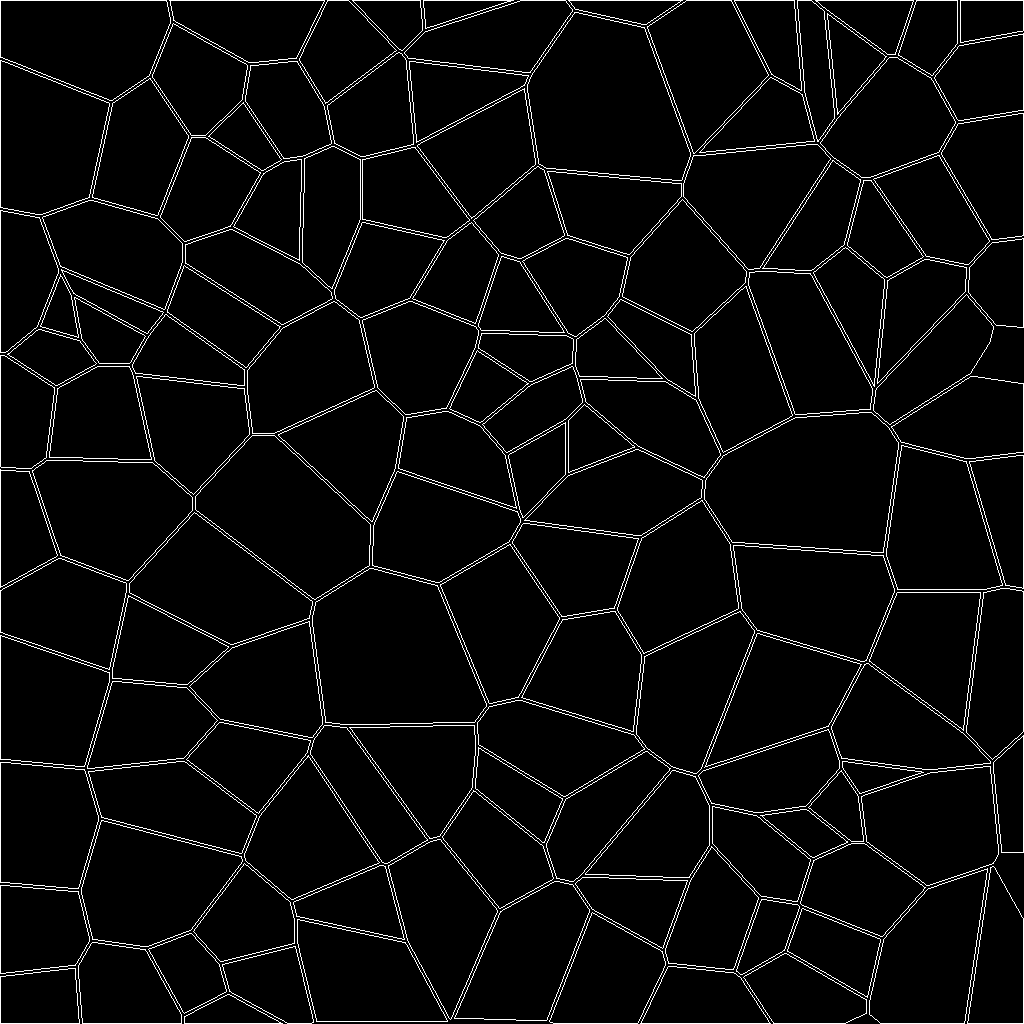

In [10]:
def contour1(image):
    image = cv2.bitwise_not(image)
    contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    valid_contours = []
    for contour in contours:
        if cv2.contourArea(contour) > 1e3 and cv2.contourArea(contour) < 1e5:
            valid_contours.append(contour)
    
    return valid_contours

temp_img = np.zeros(img.shape)
conts = contour1(dilate(bounds(img)))
cv2.drawContours(temp_img, conts, -1, 255, 1)
save_image(temp_img)
Image("temp.png")

# Contour 2

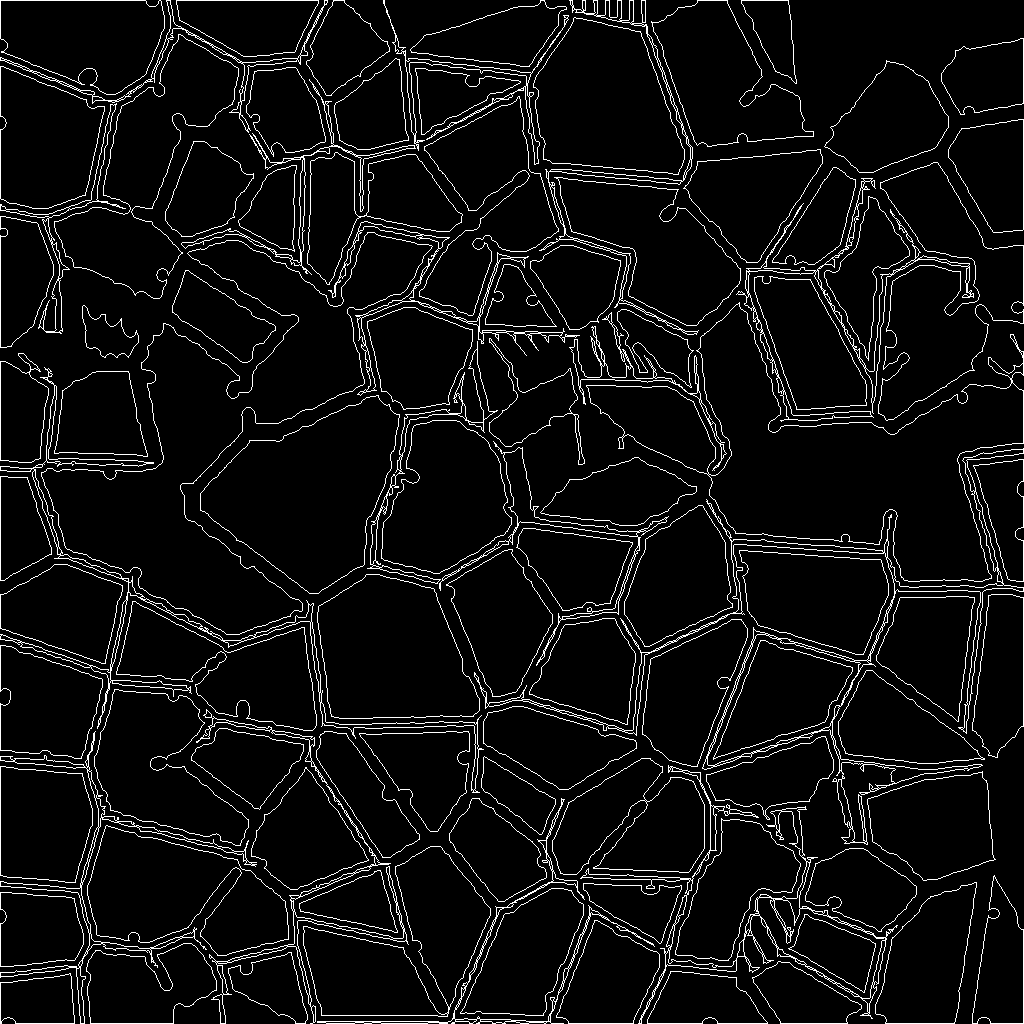

In [379]:
def contour2(image):
    thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11, 2)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    valid_contours = []
    for contour in contours:
        if cv2.contourArea(contour) > 1200 and cv2.contourArea(contour) < 100000:
            valid_contours.append(contour)
    
    return valid_contours
        

temp_img = np.zeros(img.shape)
conts = contour2(bounds(img))
cv2.drawContours(temp_img, conts, -1, 255, 1)
save_image(temp_img)
Image("temp.png")

# Inverse Contour Fill

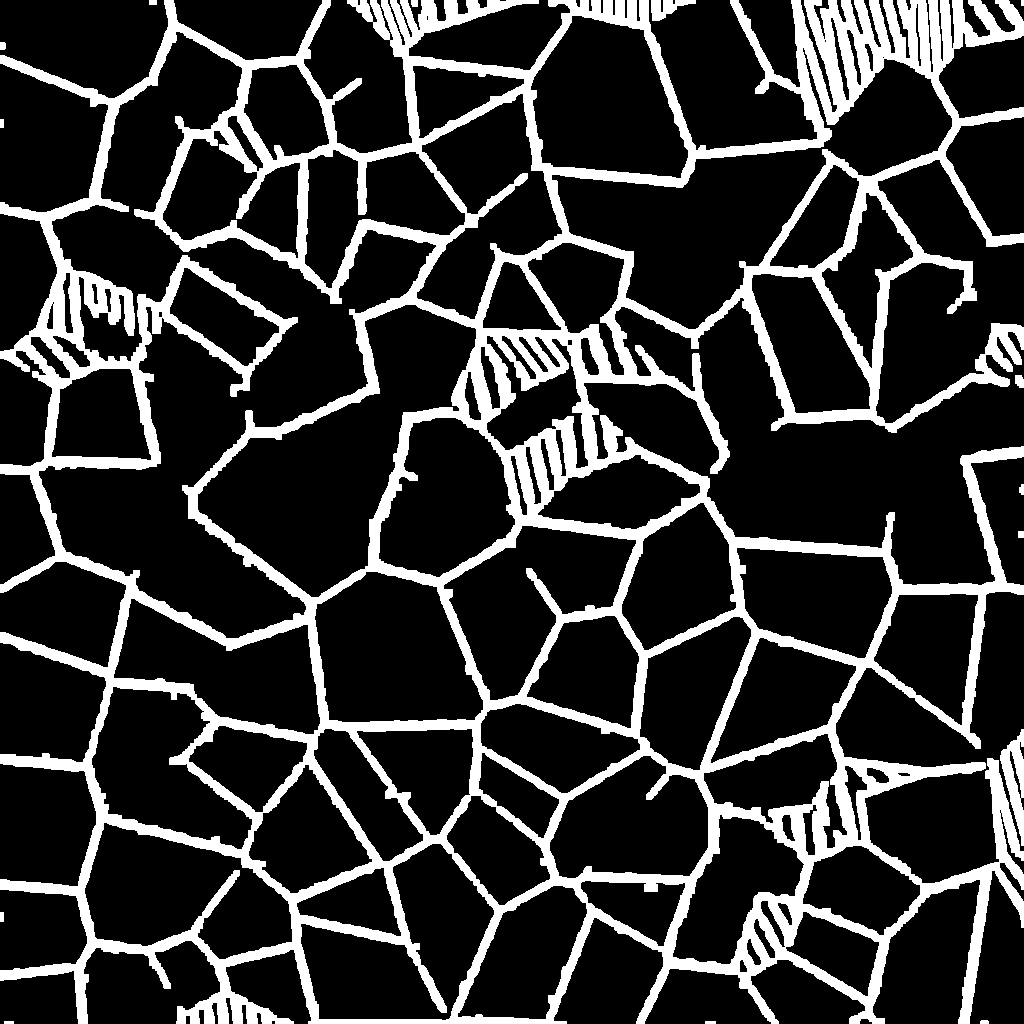

In [388]:
def fill(image):
    not_image = cv2.bitwise_not(image)
    contours, hierarchy = cv2.findContours(not_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    valid_contours = []
    for contour in contours:
        if cv2.contourArea(contour) < 1e3:
            valid_contours.append(contour)
    
    out_image = image[:]
    out_image = cv2.fillPoly(out_image, pts=valid_contours, color=0)
    
    kernel = np.ones((2,2),np.uint8)
    out_image = cv2.dilate(out_image, kernel, iterations=1)
    
    return out_image

save_image(fill1(dilate(bounds(img))))
Image("temp.png")

# Dash Mask

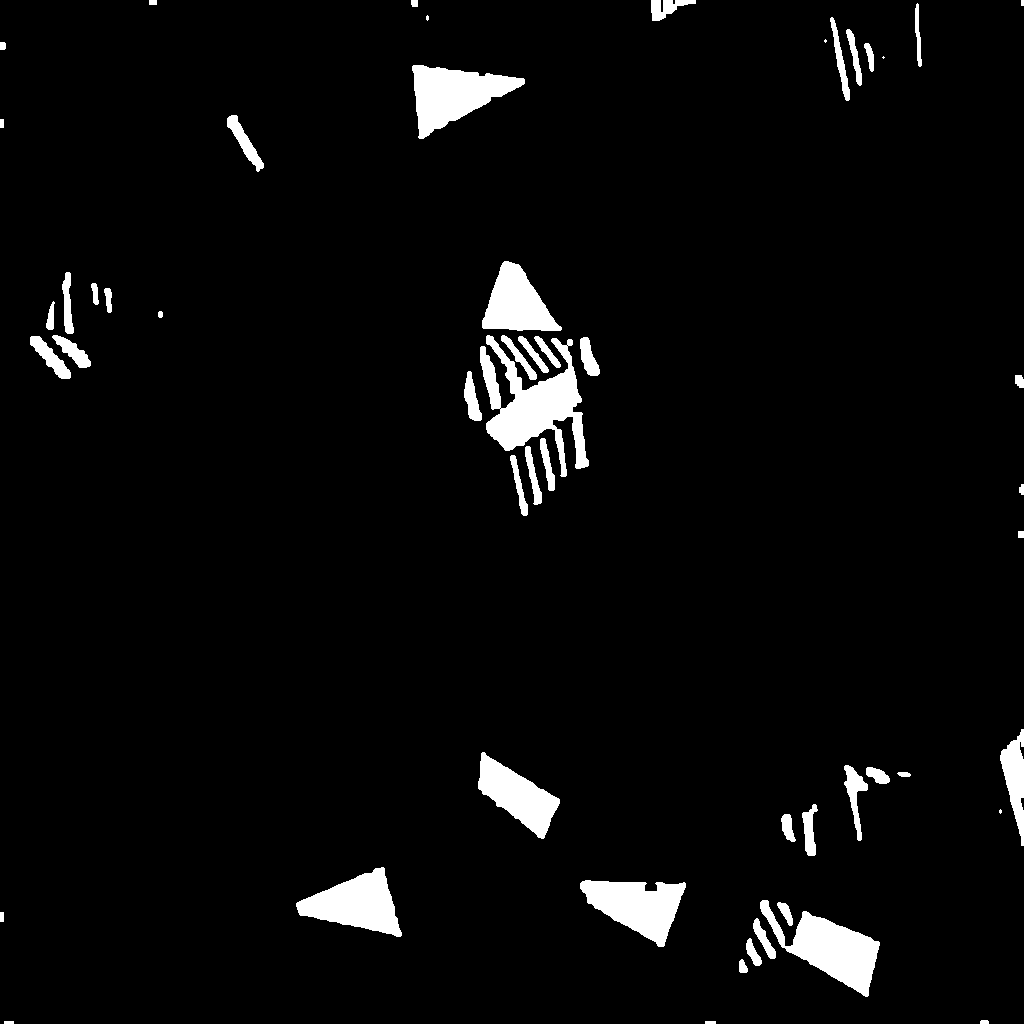

In [424]:
# def get_dash_mask(image, conts):
#     contours, _ = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

#     valid_contours = []
#     for contour in contours:
#         if cv2.contourArea(contour) < 5000:
#             valid_contours.append(contour)

#     thres = image[:]
#     thres = cv2.fillPoly(thres, pts=valid_contours, color=255)

#     kernel = np.ones((2,2),np.uint8)
#     thres = cv2.dilate(thres, kernel, iterations=10)
    
#     out_image = np.zeros(image.shape)
#     for contour in contours:
#         r = cv2.boundingRect(contour)
#         crop_img = thres[r[1]:r[1]+r[3], r[0]:r[0]+r[2]]
#         crop_img = crop_img.flatten()
#         n_pixels = len(crop_img.flatten())
#         n_whites = len([1 for p in crop_img.flatten() if p])
#         if n_whites / n_pixels > 0.75:
#             cv2.drawContours(out_image, [contour], -1, 255, -1)
    
#     return thres, out_image

# contos = contour1(fill(dilate(bounds(img))))
# im1, im2 = get_dash_mask(denoise(img), contos)
# save_image(im2)
# Image("temp.png")

# Image Processing Stack

In [322]:
!rm -r temp/*

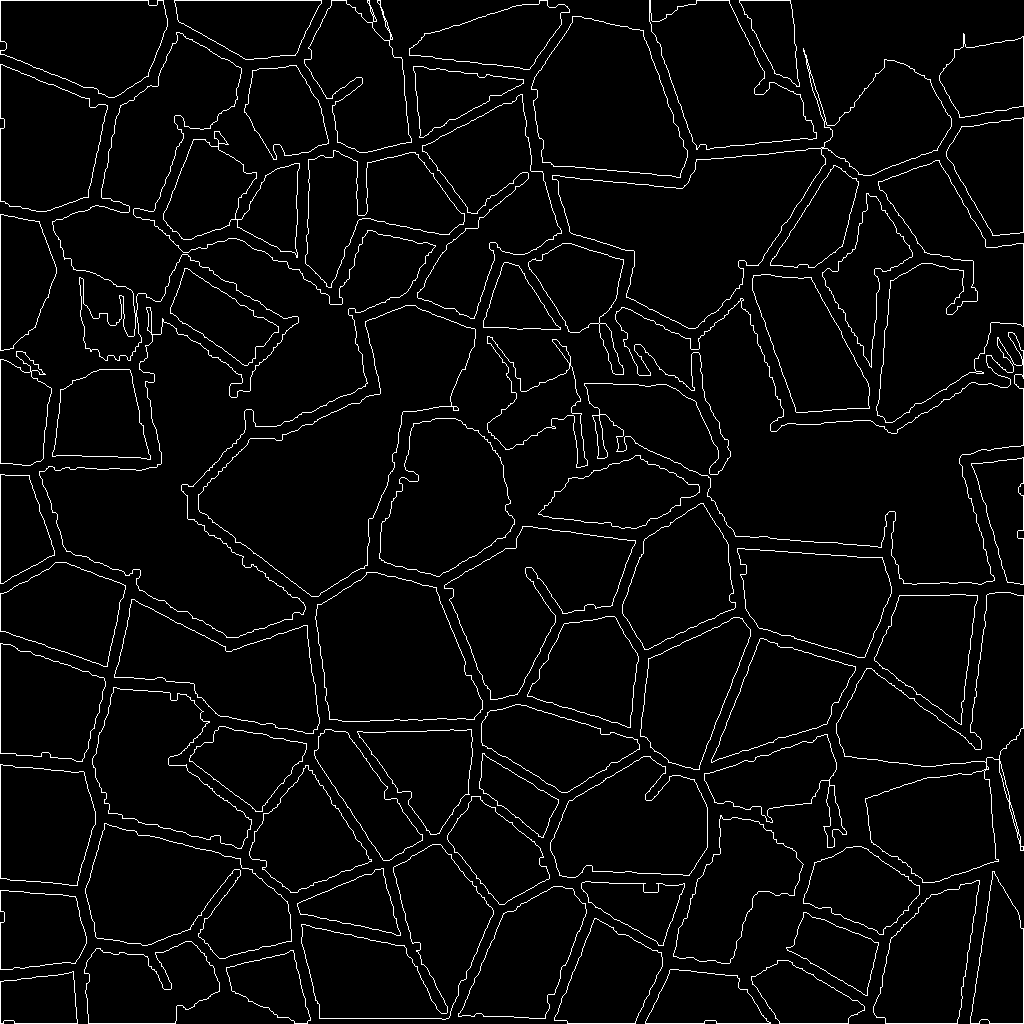

In [425]:
temp_img = np.zeros(img.shape)
conts = contour1(fill(dilate(bounds(img))))
cv2.drawContours(temp_img, conts, -1, 255, 1)
save_image(temp_img)
Image("temp.png")

In [339]:
conts = contour1(fill1(dilate(bounds(img))))
for i,cont in enumerate(conts):
    temp_img = np.zeros(img.shape)
    cv2.drawContours(temp_img, [cont], -1, 255, 1)
    cv2.imwrite("temp/img_{}.png".format(i), temp_img)

In [ ]:
# def denoise(input_image):
#     def bounds(image):
#         thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
#         _, thresh = cv2.threshold(thresh, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

#         kernel = np.ones((1, 5), np.uint8)
#         horizontal = cv2.erode(thresh, kernel, iterations=2)

#         kernel = np.ones((5, 1), np.uint8)
#         vertical = cv2.erode(thresh, kernel, iterations=2)

#         edges = horizontal + vertical
#         edges = np.array(np.where(edges == 255, 255, 0), np.uint8)

#         return edges

#     def dilate(image):
#         kernel = np.ones((5,5),np.uint8)
#         dilated = cv2.dilate(image, kernel, iterations=1)
#         return dilated

#     def fill(image):
#         not_image = cv2.bitwise_not(image)
#         contours, _ = cv2.findContours(not_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

#         valid_contours = []
#         for contour in contours:
#             if cv2.contourArea(contour) < 1e3:
#                 valid_contours.append(contour)

#         out_image = image[:]
#         out_image = cv2.fillPoly(out_image, pts=valid_contours, color=0)

#         kernel = np.ones((2,2),np.uint8)
#         out_image = cv2.dilate(out_image, kernel, iterations=1)

#         return out_image

#     return fill(dilate(bounds(input_image)))

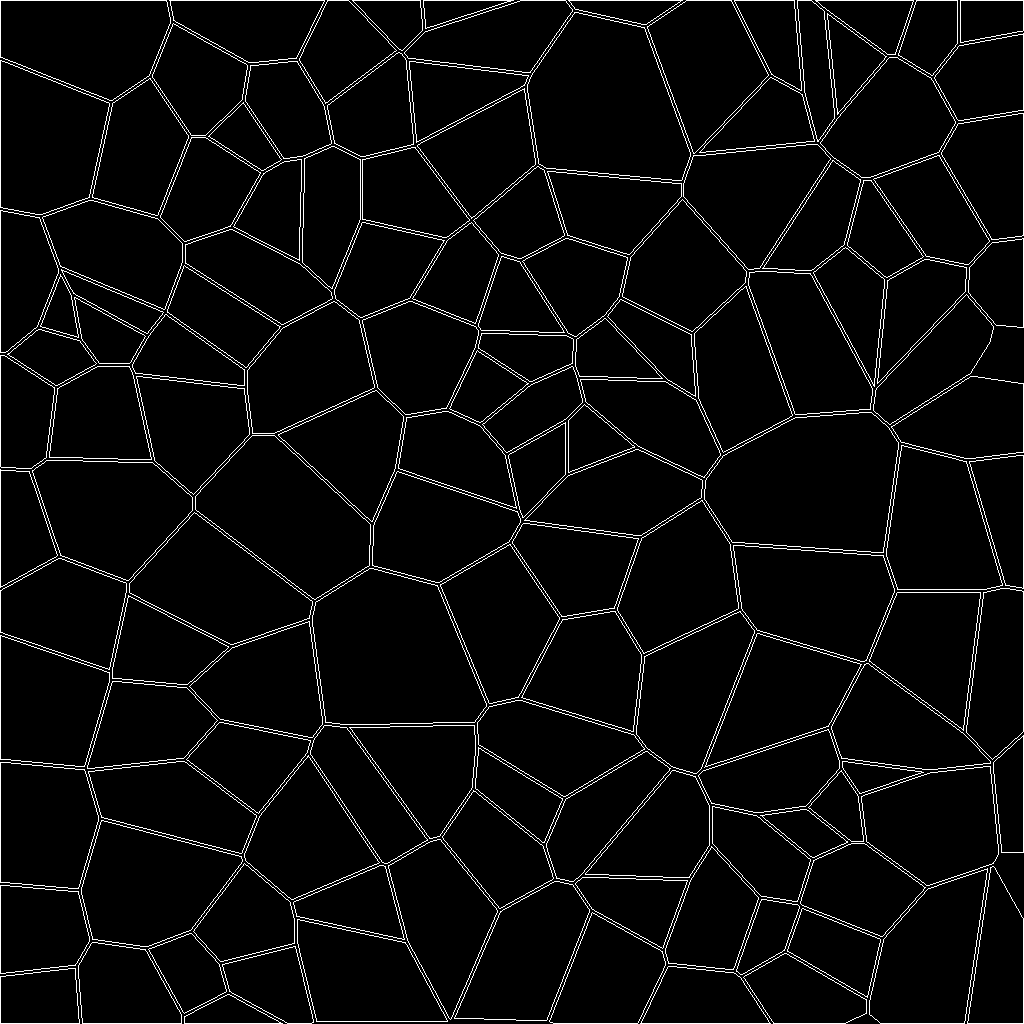

In [13]:
class Grain:
    def __init__(self, contour):
        self.contour = contour
        self.area = cv2.contourArea(self.contour)
        self.diameter = (4 * self.area / np.pi)**0.5

def foo(image):
    image = cv2.bitwise_not(image)
    contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    valid_contours = []
    for contour in contours:
        if cv2.contourArea(contour) > 1e3 and cv2.contourArea(contour) < 1e5:
            valid_contours.append(contour)

    grains = []
    for vc in valid_contours:
        grains.append(Grain(vc))

    correct_average_grain_diameter = sum([g.diameter for g in grains]) / len(self.grains)
    return correct_average_grain_diameter